In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mannan7","key":"35722e33ec1d59ca3ea4458c7de9dc9b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [01:31<00:00, 162MB/s]
100% 9.51G/9.51G [01:31<00:00, 112MB/s]


In [4]:
from zipfile import ZipFile
with ZipFile('/content/aptos2019-blindness-detection.zip', 'r') as zip_ref:
    zip_ref.extractall()
    print('Dataset extraction done')

Dataset extraction done


In [5]:
import pandas as pd
import os
import cv2
import tensorflow as tf
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, MaxPooling2D, Conv2D, Dropout, BatchNormalization, AveragePooling2D
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, cohen_kappa_score, classification_report

In [6]:
diagnosis_data = pd.read_csv('train.csv')
diagnosis_data['id_code'] = diagnosis_data['id_code'].apply(lambda x: x + '.png')
diagnosis_data.head(5)

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [7]:
one = diagnosis_data.loc[diagnosis_data['diagnosis'] == 1]
two = diagnosis_data.loc[diagnosis_data['diagnosis'] == 2]
three = diagnosis_data.loc[diagnosis_data['diagnosis'] == 3]
four = diagnosis_data.loc[diagnosis_data['diagnosis'] == 4]

In [8]:
four = pd.concat([four] * 5, ignore_index=True)
three = pd.concat([three] * 8, ignore_index=True)
two = pd.concat([two] * 1, ignore_index=True)
one = pd.concat([one] * 4, ignore_index=True)

In [9]:
balanced_data = pd.concat([diagnosis_data, four, three, two, one], ignore_index=True)

In [10]:
labels = balanced_data['diagnosis']
image_names = balanced_data['id_code']

In [11]:
image_dir = '/content/train_images'
image_paths = [os.path.join(image_dir, filename) for filename in image_names]

In [12]:
def process_and_save_images(img_paths, save_dir, size=(224, 224)):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    processed_images = []
    for index, img_path in enumerate(img_paths):
        img = cv2.imread(img_path)
        if img is None:
            continue
        resized_img = cv2.resize(img, size)
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        blurred_img = cv2.GaussianBlur(gray_img, (0, 0), size[0] / 10)
        final_img = cv2.addWeighted(gray_img, 4, blurred_img, -4, 128)
        final_img = np.expand_dims(final_img, axis=-1)

        processed_images.append(final_img)
        cv2.imwrite(os.path.join(save_dir, os.path.basename(img_path)), final_img)

        if (index + 1) % 100 == 0 or (index + 1) == len(img_paths):
            print(f"Processed {index + 1}/{len(img_paths)} images")

    return np.array(processed_images)

In [13]:
x_train_paths, x_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.20, random_state=42)

In [14]:
save_train_dir = '/content/processed_train_images'
save_test_dir = '/content/processed_test_images'

In [15]:
x_train = process_and_save_images(x_train_paths, save_train_dir)

Processed 100/7328 images
Processed 200/7328 images
Processed 300/7328 images
Processed 400/7328 images
Processed 500/7328 images
Processed 600/7328 images
Processed 700/7328 images
Processed 800/7328 images
Processed 900/7328 images
Processed 1000/7328 images
Processed 1100/7328 images
Processed 1200/7328 images
Processed 1300/7328 images
Processed 1400/7328 images
Processed 1500/7328 images
Processed 1600/7328 images
Processed 1700/7328 images
Processed 1800/7328 images
Processed 1900/7328 images
Processed 2000/7328 images
Processed 2100/7328 images
Processed 2200/7328 images
Processed 2300/7328 images
Processed 2400/7328 images
Processed 2500/7328 images
Processed 2600/7328 images
Processed 2700/7328 images
Processed 2800/7328 images
Processed 2900/7328 images
Processed 3000/7328 images
Processed 3100/7328 images
Processed 3200/7328 images
Processed 3300/7328 images
Processed 3400/7328 images
Processed 3500/7328 images
Processed 3600/7328 images
Processed 3700/7328 images
Processed 

In [16]:
x_test = process_and_save_images(x_test_paths, save_test_dir)

Processed 100/1832 images
Processed 200/1832 images
Processed 300/1832 images
Processed 400/1832 images
Processed 500/1832 images
Processed 600/1832 images
Processed 700/1832 images
Processed 800/1832 images
Processed 900/1832 images
Processed 1000/1832 images
Processed 1100/1832 images
Processed 1200/1832 images
Processed 1300/1832 images
Processed 1400/1832 images
Processed 1500/1832 images
Processed 1600/1832 images
Processed 1700/1832 images
Processed 1800/1832 images
Processed 1832/1832 images


In [17]:
x_train / 255.0
x_test / 255.0

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.09411765],
         [0.07843137],
         [0.07843137]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.09411765],
         [0.09411765],
         [0.09411765]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.09411765],
         [0.09411765],
         [0.09411765]]],


       [[[0.40784314],
         [0.40784314],
         [0.40

In [18]:
y_train.shape
x_train.shape

(7328, 224, 224, 1)

In [19]:
x_test.shape

(1832, 224, 224, 1)

In [20]:
x_train=np.reshape(x_train, (7328,224,224,1))
x_train.shape

(7328, 224, 224, 1)

In [21]:
x_test=np.reshape(x_test, (1832,224,224,1))
x_test.shape

(1832, 224, 224, 1)

In [22]:
y_train_encoded = to_categorical(y_train, num_classes=5)
y_test_encoded = to_categorical(y_test, num_classes=5)

In [23]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1)),
    AveragePooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    AveragePooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    AveragePooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    AveragePooling2D(2, 2),
    Dropout(0.6),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    AveragePooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    AveragePooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    AveragePooling2D(1, 1),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    AveragePooling2D(1, 1),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 average_pooling2d (Average  (None, 112, 112, 32)      0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 average_pooling2d_1 (Avera  (None, 56, 56, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 average_pooling2d_2 (Avera  (None, 28, 28, 64)        0

In [24]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [25]:
history = model.fit(x_train, y_train_encoded,epochs=20,batch_size=80)

Epoch 1/20
92/92 [==============================] - 20s 46ms/step - loss: 0.5441 - accuracy: 0.2228
Epoch 2/20
92/92 [==============================] - 4s 41ms/step - loss: 0.4295 - accuracy: 0.4198
Epoch 3/20
92/92 [==============================] - 4s 44ms/step - loss: 0.4080 - accuracy: 0.4681
Epoch 4/20
92/92 [==============================] - 4s 41ms/step - loss: 0.3928 - accuracy: 0.4963
Epoch 5/20
92/92 [==============================] - 4s 41ms/step - loss: 0.3769 - accuracy: 0.5169
Epoch 6/20
92/92 [==============================] - 4s 43ms/step - loss: 0.3692 - accuracy: 0.5311
Epoch 7/20
92/92 [==============================] - 4s 43ms/step - loss: 0.3551 - accuracy: 0.5529
Epoch 8/20
92/92 [==============================] - 4s 41ms/step - loss: 0.3439 - accuracy: 0.5776
Epoch 9/20
92/92 [==============================] - 4s 41ms/step - loss: 0.3274 - accuracy: 0.6051
Epoch 10/20
92/92 [==============================] - 4s 43ms/step - loss: 0.3092 - accuracy: 0.6332
Epoch 11

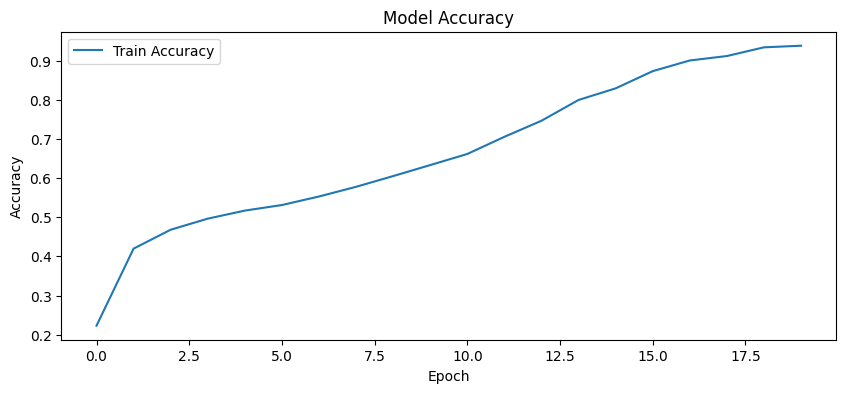

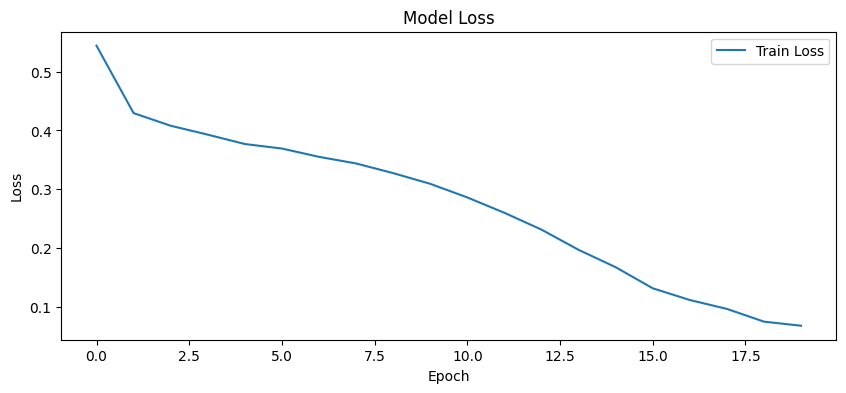

In [34]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [26]:
y_pred_prob = model.predict(x_test)

58/58 [==============================] - 1s 7ms/step


In [27]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_encoded, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

58/58 [==============================] - 1s 6ms/step - loss: 0.0922 - accuracy: 0.9252
Test Loss: 0.09221339225769043
Test Accuracy: 0.9252183437347412


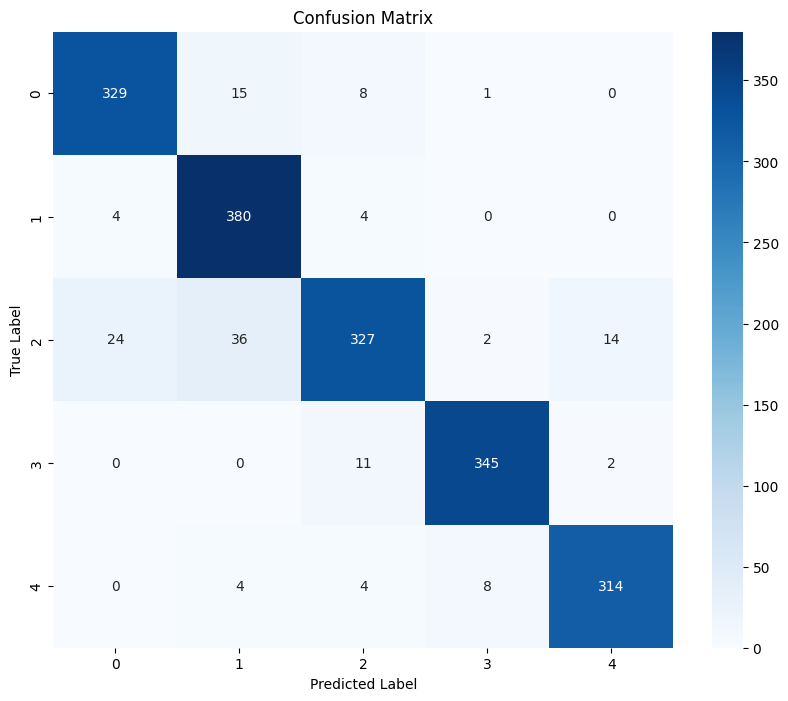

In [28]:
y_pred_class = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

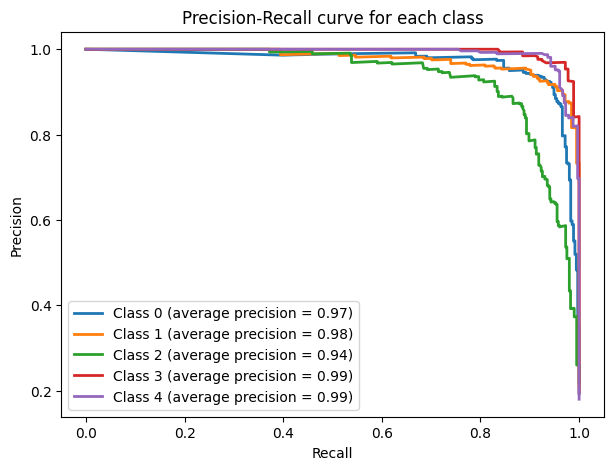

In [30]:
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_prob[:, i])

plt.figure(figsize=(7, 5))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {0} (average precision = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="best")
plt.show()

In [31]:
kappa_score = cohen_kappa_score(y_test, y_pred_class)
print(f"Cohen's Kappa score: {kappa_score}")

Cohen's Kappa score: 0.906433498495571


In [32]:
report = classification_report(y_test, y_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       353
           1       0.87      0.98      0.92       388
           2       0.92      0.81      0.86       403
           3       0.97      0.96      0.97       358
           4       0.95      0.95      0.95       330

    accuracy                           0.93      1832
   macro avg       0.93      0.93      0.93      1832
weighted avg       0.93      0.93      0.92      1832



In [41]:
from google.colab.patches import cv2_imshow

def process_single_image(img_path, size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image: {img_path}")
        return None

    resized_img = cv2.resize(img, size)
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(gray_img, (0, 0), size[0] / 10)
    final_img = cv2.addWeighted(gray_img, 4, blurred_img, -4, 128)
    final_img = np.expand_dims(final_img, axis=-1)

    return final_img

Saving t2.png to t2.png


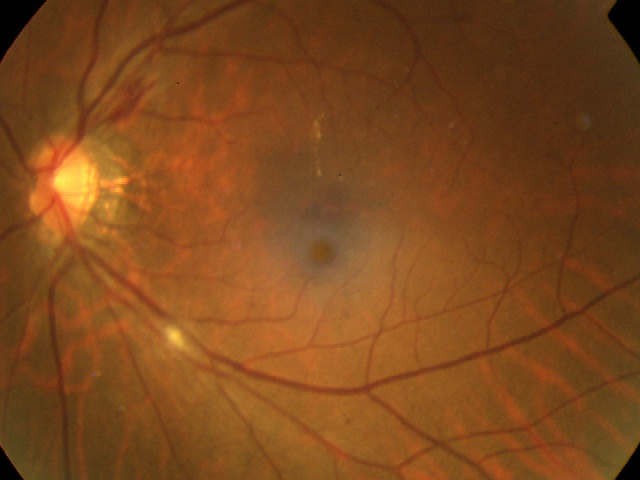

In [42]:
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
show = cv2.imread(test_image_path)
cv2_imshow(show)

In [43]:
processed_test_image = process_single_image(test_image_path)

In [44]:
reshaped_test_image = np.reshape(processed_test_image, (1, 224, 224, 1)) / 255.0

In [45]:
prediction = model.predict(reshaped_test_image)
predicted_class = np.argmax(prediction)
print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 28ms/step
Predicted Class: 2
